In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
from scipy.optimize import minimize
import pdb
from matplotlib import rc
rc('text', usetex=True)

In [5]:
%matplotlib inline

## Question 1

### (a)

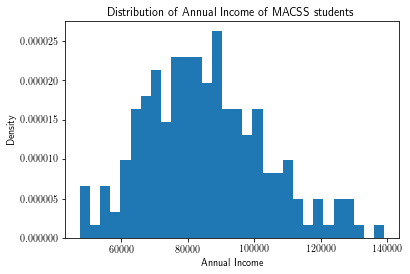

In [6]:
dt = np.loadtxt("incomes.txt")
fig, ax = plt.subplots()
ax.hist(dt, normed = True, bins= 30)
ax.set(title = "Distribution of Annual Income of MACSS students", 
       xlabel = "Annual Income", 
        ylabel = "Density")
plt.show()

### (b)

In [7]:
class GMM:
    def __init__(self):
        pass
    
    def model_moment(self, param):
        pass
    
    def error_func(self, param, W = None):
        if W is None:
            W = np.eye(len(self.data_moment))
        e = (self.model_moment(param) - self.data_moment)/self.data_moment
        return e.T @ W @ e
    
    def estimate(self, init, method = "identity", bounds = None):
        results = minimize(self.error_func, init, method='L-BFGS-B', bounds = bounds)
        if method == "identity":
            return results
        if method == "two-step":
            e = (self.model_moment(results.x) - self.data_moment)/self.data_moment
            vcv = e @ e.T / self.N
            W = np.linalg.inv(vcv)
            W = W/np.sum(W) # rescale the W in case of overflow
            results = minimize(self.error_func, results.x, args = W, method='L-BFGS-B',  bounds = bounds)
            return results
        if method == "iterate":
            W = np.eye(len(init))
            while True:
                e = (self.model_moment(results.x) - self.data_moment)/self.data_moment
                vcv = e @ e.T / self.N
                new_W = np.linalg.inv(vcv)
#                 new_W = new_W/np.sum(new_W) # rescale the W in case of overflow    
                if np.sum(np.abs(new_W - W))>1e-7:
                    W = new_W
                    results = minimize(self.error_func, results.x, args = (W), method='L-BFGS-B',  bounds = bounds)
                else:
                    return results
                    
                
        
class Log_Normal(GMM):
    def __init__(self, data):
        self.N = len(data)
        self.data = data
        self.data_moment = np.array((np.mean(self.data), np.std(self.data))).reshape((2,1))
        
    def model_moment(self, param):
#       Given the formula of model moment is easily calculated analytically,
#       I use the expression directly here instead of numerical integral to avoid inaccuracy and addtional offhead.
        param = np.array(param).reshape(2, 1)
        mean = np.exp(np.array((1, 0.5)).reshape((1,2)) @ param)
        std = np.sqrt(np.exp(np.array((2, 1)).reshape((1,2)) @ param) * (np.exp(param[1,:]) - 1))
        return np.concatenate((mean, std), axis = 0)
    
    def pdf(self, x, param):
        mu, sigma2 = param
        sigma = np.sqrt(sigma2)
        return 1/x/sigma/np.sqrt(2*np.pi) * np.exp(-(np.log(x)-mu)**2/2/sigma/sigma)
    

In [8]:
ln = Log_Normal(dt)
results = ln.estimate((11, 0.2), bounds = ((None, None), (1e-10, None)))


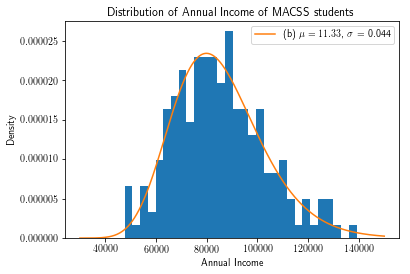

In [9]:
x = np.linspace(30000, 150000, 1000)
y = ln.pdf(x, results.x)
ax.plot(x, y, label = "(b) $\mu= {}$, $\sigma$ = {}$".format(round(results.x[0], 2),
                                                            round(results.x[1], 3)))
ax.legend()
fig

In [11]:
print("The estimated mu = {}, and sigma = {}: ".format(results.x[0], np.sqrt(results.x[1])))
print("The value of criterion function at the estimated paramter values is:")
print(results.fun[0])
print("Two data momments is ")
print(ln.data_moment)
print("Two model moment is ")
print(ln.model_moment(results.x))


The estimated mu = 11.33188203192565, and sigma = 0.20869644276782326: 
[ 11.33188203   0.04355421]
The value of criterion function at the estimated paramter values is:
[  1.31026882e-12]
Two data momments is 
[[ 85276.82360626]
 [ 17992.54212805]]
Two model moment is 
[[ 85276.92103295]
 [ 17992.54340264]]


Model moments and data moments are very close.

### (c)

In [ ]:
results2 =  ln.estimate((11, 0.2), method = "two-step")
x = np.linspace(30000, 150000, 1000)
y = ln.pdf(x, results2.x)
ax.plot(x, y, label = "(c) $\mu= {}$, $\sigma$ = {}$".format(round(results2.x[0], 2),
                                                            round(results2.x[1], 3)))
ax.legend()
fig

In [ ]:
print("The estimate for mu and sigma^2 is: ")
print(results2.x)
print("The value of criterion function at the estimated paramter values is:")
print(results2.fun[0])
print("Two data momments is ")
print(ln.data_moment)
print("Two model moment is ")
print(ln.model_moment(results2.x))

I also implemented a iterative version, which yields the same result. See below.

In [ ]:
results3 = ln.estimate((11, 0.2), method = "iterate", bounds = ((None, None), (1e-10, None)))

In [ ]:
results3.x

### (d)

In [ ]:
from scipy.stats import norm
class Log_Normal2(Log_Normal):
    def __init__(self, data):
        self.N = len(data)
        self.data = data
        data = np.array(data)
        m1 = sum(data<75000)/len(data)
        m2 = np.all((data>=75000, data<=100000), axis = 0).sum()/len(data)
        m3 = sum(data>100000)/len(data)
        self.data_moment = np.array((m1,m2,m3)).reshape((3,1))
        
    def model_moment(self, param):
#       Given the formula of model moment is easily calculated analytically,
#       I use the expression directly here instead of numerical integral to avoid inaccuracy and addtional offhead.
        mu, sigma2 = param
        m1 = norm.cdf(np.log(75000), loc = mu, scale = np.sqrt(sigma2))
        m2 = norm.cdf(np.log(100000), loc = mu, scale = np.sqrt(sigma2)) - m1
        m3 = 1 - norm.cdf(np.log(100000), loc = mu, scale = np.sqrt(sigma2))
        return np.array((m1,m2,m3)).reshape((3,1))
    

In [ ]:
ln2 = Log_Normal2(dt)

In [ ]:
results4 = ln2.estimate((11, 0.5), bounds = ((None, None), (1e-10, None)))
print(results4.x)

In [ ]:
x = np.linspace(30000, 150000, 1000)
y = ln.pdf(x, results4.x)
ax.plot(x, y, label = "(d) $\mu= {}$, $\sigma$ = {}$".format(round(results4.x[0], 2),
                                                            round(results4.x[1], 3)))
ax.legend()
fig

### (e)

In [ ]:
ln2.estimate((11, 0.5), method = "two-step", bounds = ((None, None), (1e-10, None)))

The results are the same as those in (d).

To validate our results, I choose $\mu$ and $\sigma^2$ as the target moments and do the estimate.

In [ ]:
class Log_Normal3(Log_Normal):

    def error_func(self, param, W = None):
        if W is None:
            W = np.eye(len(self.data_moment))
        e = (self.model_moment(param) - self.data_moment)
        return e.T @ W @ e
    
    def __init__(self, data):
        self.N = len(data)
        logdata = np.log(data)
        self.data_moment = np.array([[logdata.mean()], [logdata.var()]])
        
    def model_moment(self, param):
        return np.array(param).reshape((2,1))

In [ ]:
ln3 = Log_Normal3(dt)
ln3.estimate((11, 1), bounds = ((None, None), (1e-10, None)))

The same as hour first GMM results.

## Part 2

In [ ]:
import pandas as pd
sick = pd.read_csv("sick.txt")

In [ ]:
class Linear_Regression(GMM):
    
    def error_func(self, param, W = None):
        if W is None:
            W = np.eye(len(self.data_moment))
        e = (self.model_moment(param) - self.data_moment)
        return e.T @ W @ e
    
    def __init__(self, data):
        self.data = data.values
        self.N = self.data.shape[0]
        self.data_moment = data.iloc[:,0].values
    
    def model_moment(self, param):
        param = np.array(param)
        X = np.concatenate((np.ones((self.N,1)),self.data[:,1:]), axis = 1)
        return X @ param

In [ ]:
lr = Linear_Regression(sick)
res = lr.estimate((1,1,1,1))

In [ ]:
res.x

The same results as Problem set 2.